# Analyse de base des fichiers éducation nationale. 
Objectif : voir les données, trouvé des pistes pour comprendre l'echec scolaire.

In [80]:
# import bibliothéques d'analyse de python
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
from os import remove

import fonctions.perso_stats as perso_stats


In [81]:
college_resultat = pd.read_csv("donnee/fr-en-indicateurs-valeur-ajoutee-colleges.csv",sep=";")
collegue_stat = pd.read_csv("donnee/fr-en-ips-colleges-ap2022.csv",sep=";")
effectif_colleges = pd.read_csv("donnee/fr-en-college-effectifs-niveau-sexe-lv.csv",sep=";")

## Affichage des entêtes des données
Pour les écoles primaires :

In [82]:
effectif_colleges.head(1)

,rentree_scolaire,region_academique,academie,departement,commune,numero_college,denomination_principale,patronyme,secteur,rep,...,3eme_lv1_allemand,3eme_lv1_anglais,3eme_lv1_espagnol,3eme_lv1_autres,3eme_lv2_allemand,3eme_lv2_anglais,3eme_lv2_espagnol,3eme_lv2_italien,3eme_lv2_autres,code_postal
0,2019,AUVERGNE-ET-RHONE-ALPES,LYON,RHONE,VILLEURBANNE,0691664J,COLLEGE,JEAN JAURES,PUBLIC,1,...,0,175,0,0,26,0,131,14,0,69100.0


In [83]:
collegue_stat.head(1)

,rentree_scolaire,academie,code_du_departement,departement,uai,nom_de_l_etablissment,code_insee_de_la_commune,nom_de_la_commune,secteur,effectifs,ips,ecart_type_de_l_ips
0,2022-2023,LYON,001,AIN,0010002X,COLLEGE SAINT EXUPERY,01004,AMBERIEU EN BUGEY,public,686.0,95.3,34.2


In [84]:
college_resultat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6622 entries, 0 to 6621
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   session                             6622 non-null   int64  
 1   uai                                 6622 non-null   object 
 2   nom_de_l_etablissement              6622 non-null   object 
 3   commune                             6622 non-null   object 
 4   departement                         6622 non-null   object 
 5   academie                            6622 non-null   object 
 6   secteur                             6622 non-null   object 
 7   nb_candidats_g                      6622 non-null   int64  
 8   taux_de_reussite_g                  6622 non-null   float64
 9   va_du_taux_de_reussite_g            6622 non-null   object 
 10  nb_candidats_p                      3126 non-null   object 
 11  taux_de_reussite_p                  3126 no

# premier nettoyage

Standariser les catègories public privé dans la colonne secteur.<br>
Standariser les rentrées scolaires<br>
Voir pour réduire le nombre de colonne des fichiers.<br>
college voir pour aggreger les classes. (langue séparé, est ce utile pour stats generale ?)<br>


In [85]:
# Les colleges de mayotte et de de guyane On des résultats inattendu selon la notice. Il ont mis ND à la place de certain taux
# Certain éléve n avait pas de trace de leur passage en 6ieme, donc Il ont une valeur ND
# Je passe ces valeur en Nan pour pouvoir travailler avec ces taux en numerique
college_resultat['taux_d_acces_6eme_3eme'].replace("ND",np.nan,inplace=True)
college_resultat['taux_d_acces_6eme_3eme'] = college_resultat['taux_d_acces_6eme_3eme'].astype('float')

In [86]:
collegue_stat['secteur'].unique()

array(['public', 'privé sous contrat'], dtype=object)

In [87]:
effectif_colleges['secteur'].unique()

array(['PUBLIC', 'PRIVE'], dtype=object)

In [88]:
# changement dans les data ecole_stat['secteur'] et college_stat['secteur']
# Les valeurs doivent être PRIVE ou PUBLIC
collegue_stat['secteur'].replace({'public':'PUBLIC','privé sous contrat':'PRIVE'},inplace=True)

In [89]:
effectif_colleges['rentree_scolaire'].unique()

array([2019, 2020, 2022, 2021])

In [90]:
collegue_stat['rentree_scolaire'].unique()

array(['2022-2023'], dtype=object)

In [91]:
# remplacer dans les données ecoles_stat et college_stat colonne rentree_scolaire 2022-2023 par 2022
collegue_stat['rentree_scolaire'].replace({'2022-2023':2022},inplace=True)

In [92]:
# création fichier college
fichier_college = pd.merge(effectif_colleges,collegue_stat,left_on=['rentree_scolaire','numero_college'],right_on=['rentree_scolaire','uai'],how='outer')

In [93]:
# supprime les colonnes en trop (doublons)
fichier_college.drop(columns=['academie_y','departement_y','secteur_y'],inplace=True)
# renomme les colonnes avec un _x
fichier_college.rename(columns={'academie_x':'academie','departement_x':'departement','secteur_x':'secteur'},inplace=True)

In [94]:
#enlevé les langues
langue = ['eme_lv1_allemand','eme_lv1_anglais','eme_lv1_espagnol','eme_lv1_autres','eme_lv2_allemand','eme_lv2_anglais','eme_lv2_espagnol','eme_lv2_italien','eme_lv2_autres']
for a in range(3,7,1):
    for b in langue:
        fichier_college.drop(columns=str(a)+b,inplace=True)


In [95]:
# enlevé les colonne commune avant le merge
college_resultat.drop(columns=['nom_de_l_etablissement','commune','departement','academie','secteur',],inplace=True)

In [96]:
fichier_college = pd.merge(fichier_college,college_resultat,left_on='numero_college',right_on='uai',how='outer')

In [97]:
fichier_college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32982 entries, 0 to 32981
Data columns (total 67 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rentree_scolaire                          32982 non-null  int64  
 1   region_academique                         32982 non-null  object 
 2   academie                                  32982 non-null  object 
 3   departement                               32982 non-null  object 
 4   commune                                   32982 non-null  object 
 5   numero_college                            32982 non-null  object 
 6   denomination_principale                   32982 non-null  object 
 7   patronyme                                 32927 non-null  object 
 8   secteur                                   32982 non-null  object 
 9   rep                                       32982 non-null  int64  
 10  rep_plus                          

In [98]:
fichier_college.drop(columns=['uai_x','uai_y','nom_de_la_commune','nom_de_l_etablissment','code_du_departement'],inplace=True)

In [99]:
fichier_college.to_csv("donnee_temp/college.csv",index=False)

## graphes France généraux au collège :
voir l évolution des effectifs globale des effectifs au college<br>
voir la repartition dans les classes en 2022<br>

In [100]:
# style graphe :
sns.set_theme(style="whitegrid")
plt.style.use("dark_background")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [101]:
# agregation des données pour vu française

# Mettre ici les données à moyenner/autre  au lieu de sommer
dico_mean = {
    "effectifs":'mean',
    'ips':'mean',
    'ecart_type_de_l_ips':'mean',
    'taux_de_reussite_g':"mean",
    'note_a_l_ecrit_g':'mean',
    'part_presents_3eme_ordinaire_total':'mean',
    'taux_d_acces_6eme_3eme':'mean'  
}

france_college_mean = fichier_college.groupby(by='rentree_scolaire').agg(dico_mean,numeric_only=True)
for key in dico_mean:
    fichier_college.drop(columns=key,inplace=True)    

france_college = fichier_college.groupby(by='rentree_scolaire').sum(numeric_only=True)

france_college.reset_index(inplace=True)
france_college_mean.reset_index(inplace=True)
france_college = pd.merge(france_college,france_college_mean,on=['rentree_scolaire'],how='outer')

# rajout de colonne pour graphes
france_college['pourcentage_ulis_total'] = france_college['nombre_eleves_ulis']/france_college['nombre_eleves_total']*100
france_college['pourcentage_segpa_total'] = france_college['nombre_eleves_segpa']/france_college['nombre_eleves_total']*100

for classe in range(3,7,1):
    classe_total = str(classe)+"eme_total"
    classe_ulis = str(classe)+"eme_ulis"
    pourcentage_ulis = 'pourcentage_ulis_'+str(classe)+'ieme'
    france_college[pourcentage_ulis] = france_college[classe_ulis]/france_college[classe_total]*100

#économie de memoire :
del france_college_mean

valeur ajouté au collegue : resultat par rapport à la population du lycée 

In [102]:
france_college.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4 entries, 0 to 3
Data columns (total 51 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rentree_scolaire                          4 non-null      int64  
 1   rep                                       4 non-null      int64  
 2   rep_plus                                  4 non-null      int64  
 3   nombre_eleves_total                       4 non-null      int64  
 4   nombre_eleves_total_hors_segpa_hors_ulis  4 non-null      int64  
 5   nombre_eleves_segpa                       4 non-null      int64  
 6   nombre_eleves_ulis                        4 non-null      int64  
 7   6eme_total                                4 non-null      int64  
 8   6eme_hors_segpa_hors_ulis                 4 non-null      int64  
 9   6eme_segpa                                4 non-null      int64  
 10  6eme_ulis                                 

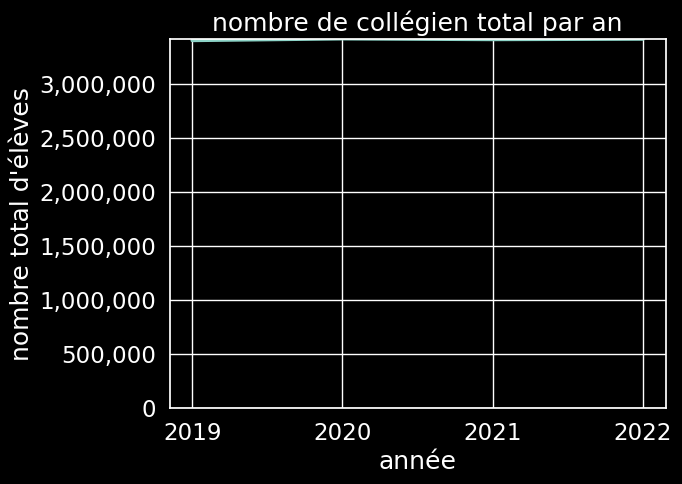

In [103]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='nombre_eleves_total',ax=ax)
ax.set_ylim(0)
ax.ticklabel_format(axis='y',style='plain')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))
ax.set_title("nombre de collégien total par an")
ax.set_xlabel("année")
ax.set_ylabel("nombre total d'élèves")
plt.show()

Nous avons environ 3 millions de collegien.

In [104]:
#trouver comment avoir le nombre de classe des colleges

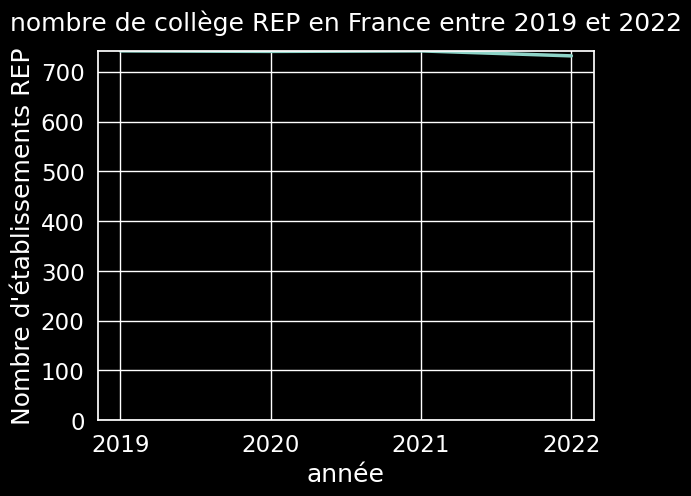

In [105]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='rep',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre de collège REP en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Nombre d'établissements REP")
ax.set_ylim(0)
plt.show()

Le nombre d'etablissement en REP baisse très legèrement.

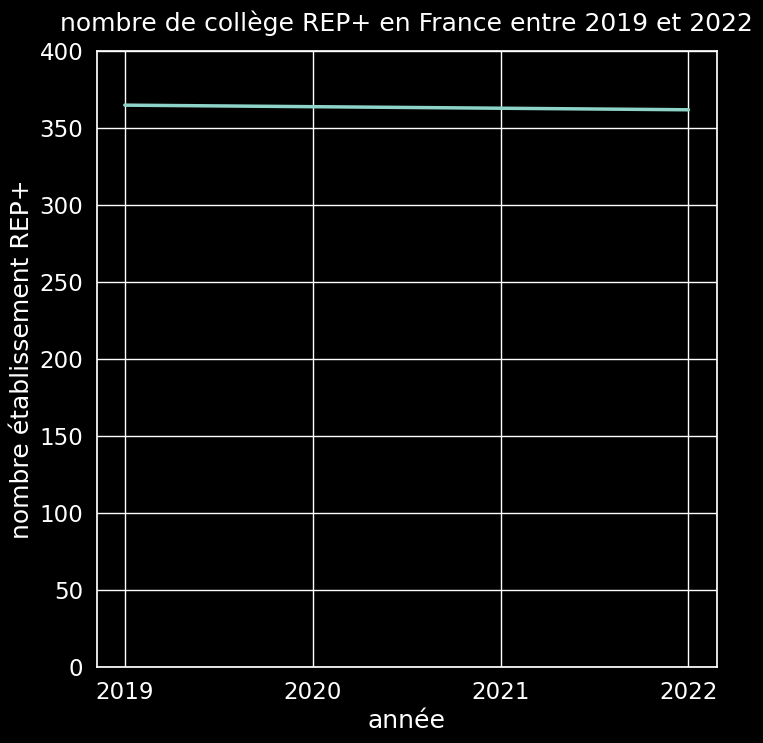

In [106]:
fig,ax = plt.subplots()
fig.set_size_inches(8,8)
sns.lineplot(data=france_college,x='rentree_scolaire',y='rep_plus',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre de collège REP+ en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("nombre établissement REP+")
ax.set_ylim(0,400)
plt.show()

Le nombre détablissement en REP+ est en légére baisse aussi.

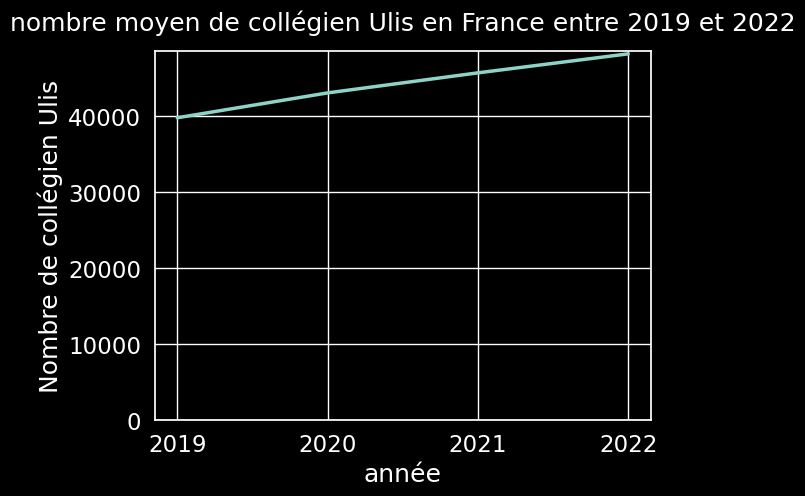

In [107]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='nombre_eleves_ulis',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre moyen de collégien Ulis en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Nombre de collégien Ulis")
ax.set_ylim(0)
plt.show()

Augmentation des éléves Ulis au collège

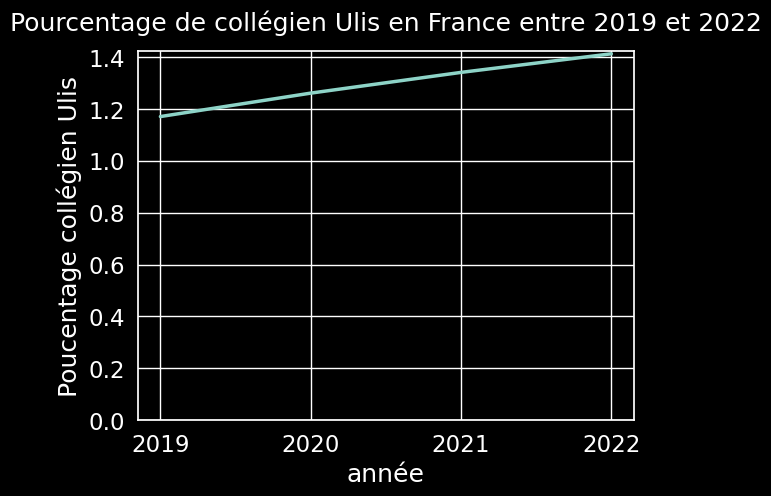

In [108]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='pourcentage_ulis_total',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Pourcentage de collégien Ulis en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Poucentage collégien Ulis")
ax.set_ylim(0)
plt.show()

On a un pourcentage de collégien Ulis en augmentation. 

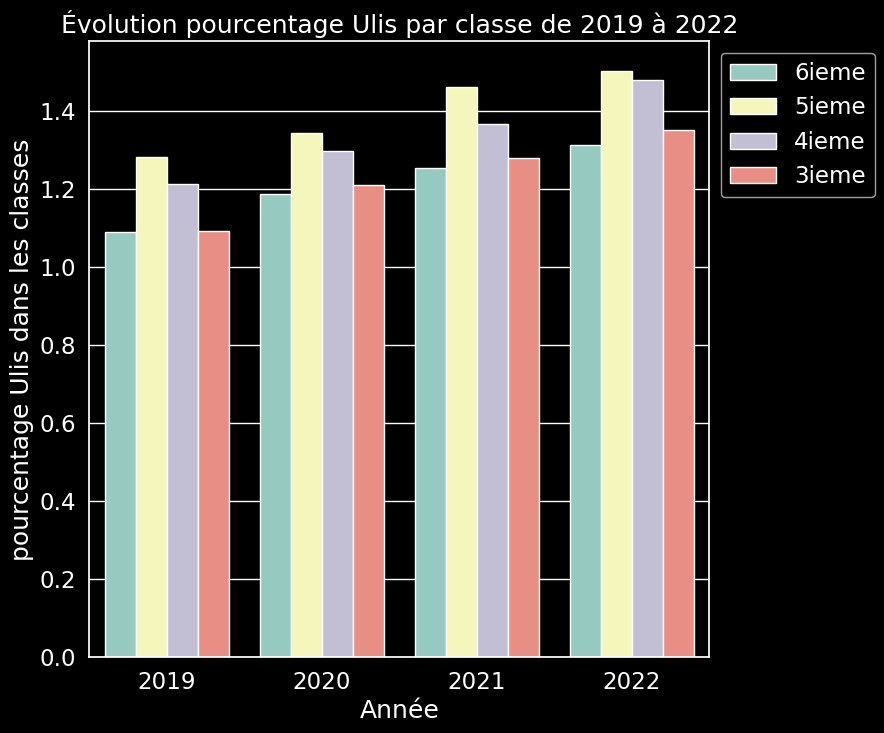

In [109]:

pourcentage_ulis_college = france_college.melt(id_vars='rentree_scolaire',
                                                value_vars=['pourcentage_ulis_6ieme','pourcentage_ulis_5ieme','pourcentage_ulis_4ieme','pourcentage_ulis_3ieme'],
                                                var_name='classe',
                                                value_name='pourcentage')

fig,ax=plt.subplots()
fig.set_size_inches(8,8)

sns.barplot(data=pourcentage_ulis_college,
            x='rentree_scolaire',
            y='pourcentage',
            hue='classe',
            ax=ax,            
            )

ax.set_title("Évolution pourcentage Ulis par classe de 2019 à 2022")
ax.set_xlabel("Année")
ax.set_ylabel("pourcentage Ulis dans les classes")

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,labels=['6ieme','5ieme','4ieme','3ieme'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()
del pourcentage_ulis_college

Les Ulis sont souvent en 5ieme et 4ieme principalement.

A savoir : On peux un enfants peut quitter le status ulis pour revenir en classe normale s'il a une bonne inclusion.Ce qui explique que les éléves ulis baisse en 3ieme. (brevet + orientation sans l´etiquette "ulis").<br>
Les changements aux colléges peuvent permettre de detecter des problémes.<br>
Il y a donc une intégration des èlèves en Ulis l'année d'après. 

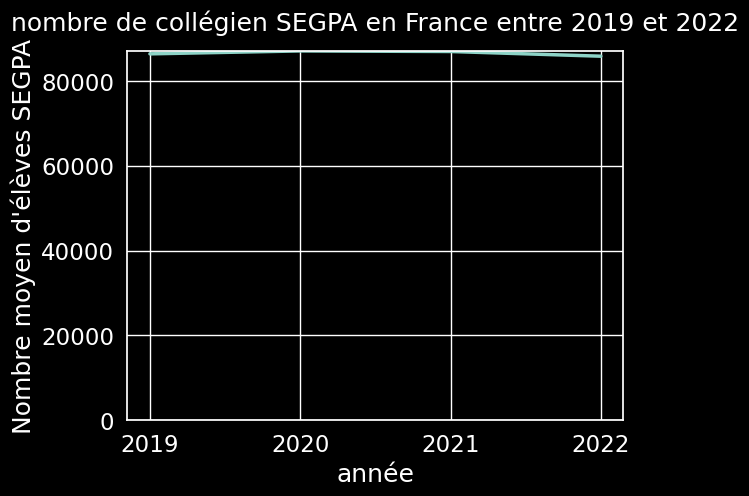

In [110]:
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='nombre_eleves_segpa',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre de collégien SEGPA en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Nombre moyen d'élèves SEGPA")
ax.set_ylim(0)
plt.show()

Le nombre de collègien segpa reste stable avec une lègère baisse en 2022.

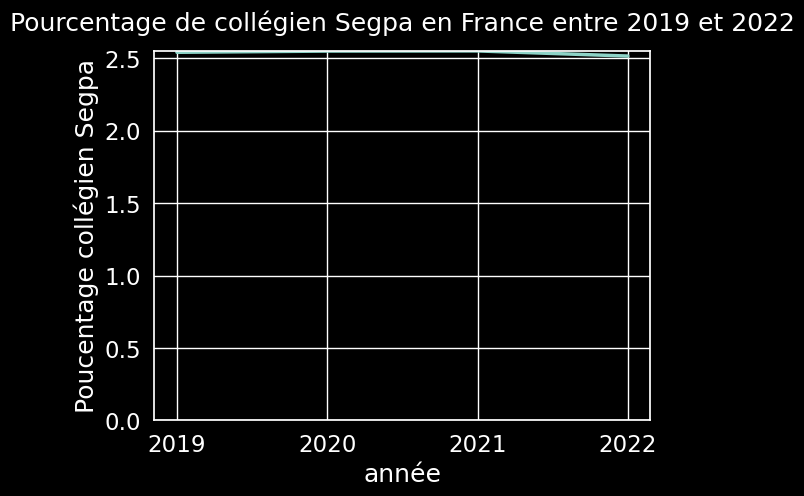

In [111]:
#SEGPA pourcentage
fig,ax = plt.subplots()
sns.lineplot(data=france_college,x='rentree_scolaire',y='pourcentage_segpa_total',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Pourcentage de collégien Segpa en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Poucentage collégien Segpa")
ax.set_ylim(0)
plt.show()

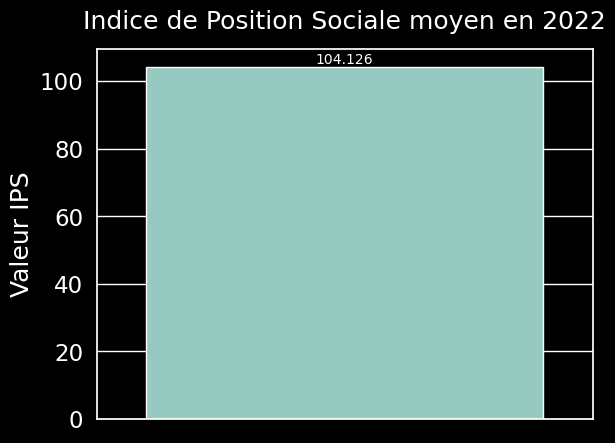

In [112]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, y="ips",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Indice de Position Sociale moyen en 2022",pad=15)
ax.set_ylabel("Valeur IPS")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

valeur de l'indice IPS (indice de position sociale): 104.126

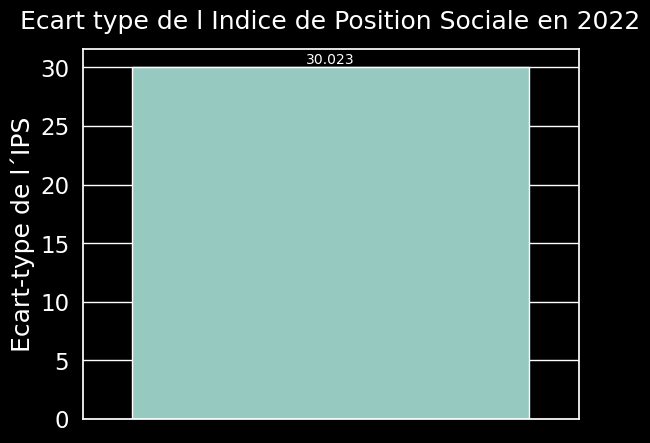

In [113]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, y="ecart_type_de_l_ips",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Ecart type de l Indice de Position Sociale en 2022",pad=15)
ax.set_ylabel("Ecart-type de l´IPS")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

Il y a un écart type moyen de l'IPS de 30

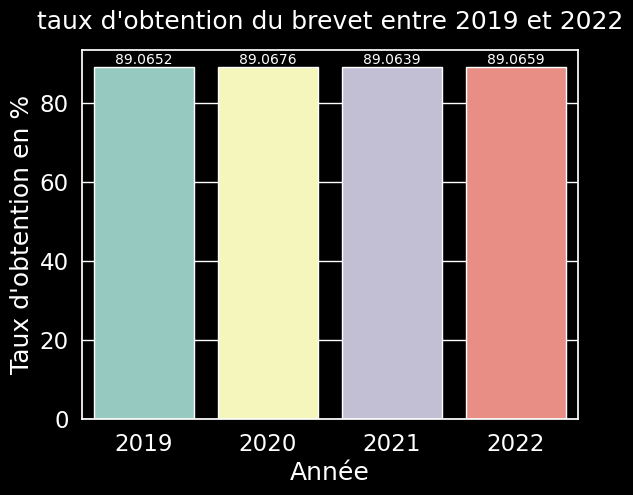

In [114]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, x="rentree_scolaire", y="taux_de_reussite_g",ax=ax,estimator="sum",errorbar=None)
ax.set_title("taux d'obtention du brevet entre 2019 et 2022",pad=15)
ax.set_ylabel("Taux d'obtention en %")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

On a un taux stable de près de 90%.<br>
9 éléve sur 10. 

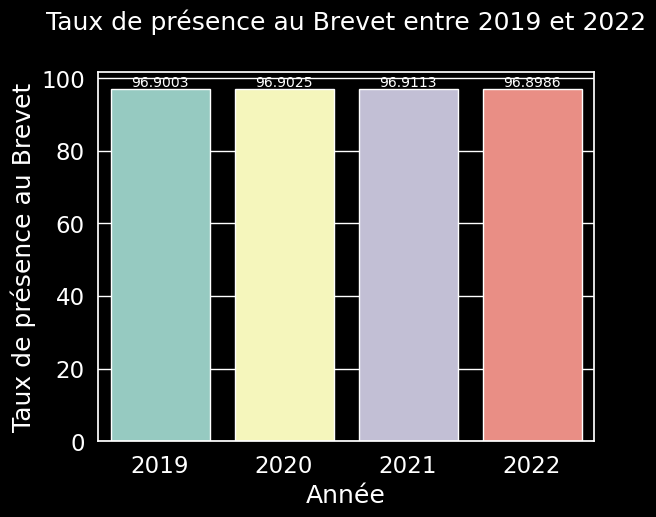

In [115]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, x="rentree_scolaire", y="part_presents_3eme_ordinaire_total",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Taux de présence au Brevet entre 2019 et 2022",pad=30)
ax.set_ylabel("Taux de présence au Brevet")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

4% des élèves ne se pésentent pas à l'examen.

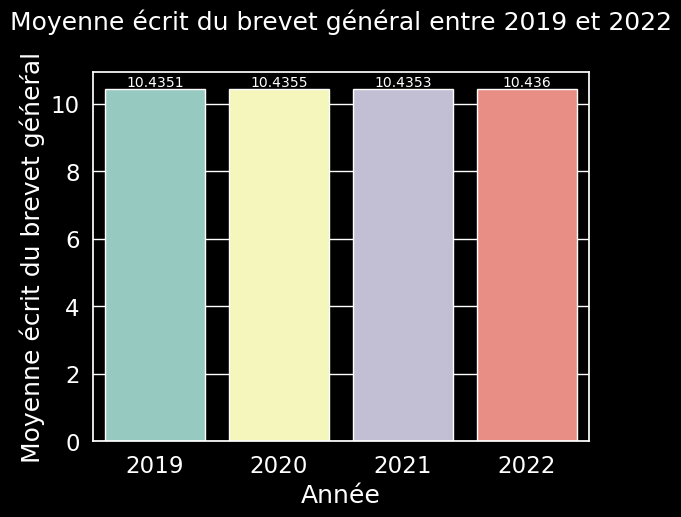

In [116]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, x="rentree_scolaire", y="note_a_l_ecrit_g",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Moyenne écrit du brevet général entre 2019 et 2022",pad=30)
ax.set_ylabel("Moyenne écrit du brevet géńeŕal")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

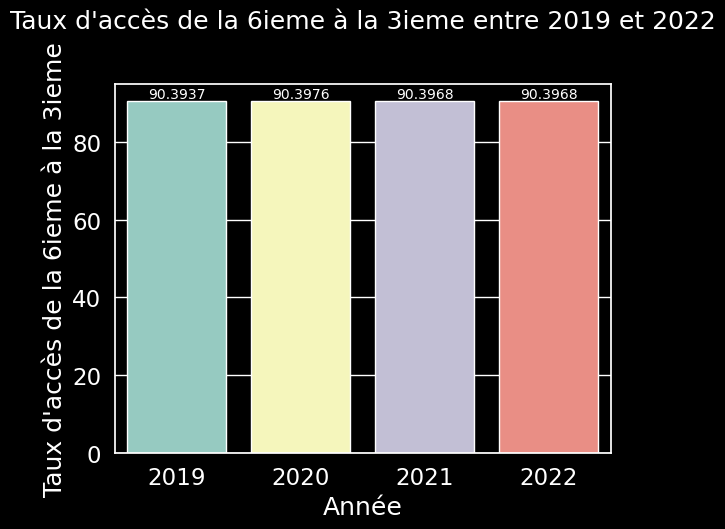

In [117]:
fig,ax = plt.subplots()
sns.barplot(data=france_college, x="rentree_scolaire", y='taux_d_acces_6eme_3eme',ax=ax,estimator="sum",errorbar=None)
ax.set_title("Taux d'accès de la 6ieme à la 3ieme entre 2019 et 2022",pad=40)
ax.set_ylabel("Taux d'accès de la 6ieme à la 3ieme")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

Le taux d'accès de la 6 ieme à la 3ieme : Pourcentage d'éléve qui ont fait leurs scolarité entiere dans le college.<br>
Les redoublants, les déménagements, les changements du à une option indisponible dans le collège ne sont pas pris en compte dans cet indiquateur.<br>

Les éléves restent à 90% dans leurs établisements.<br>

In [118]:
#nettoyage memoire
del france_college

## Analyse orienté public privé
Les colleges privée ont-ils de meileurs résultats? 

In [119]:
fichier_college = pd.read_csv('donnee_temp/college.csv',dtype={'code_insee_de_la_commune': str,
                                                                'part_presents_3eme_ordinaire_g' : str,
                                                                'part_presents_3eme_ordinaire_p': str,
                                                                'part_presents_3eme_segpa_total' : str})

In [120]:
fichier_college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32982 entries, 0 to 32981
Data columns (total 62 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rentree_scolaire                          32982 non-null  int64  
 1   region_academique                         32982 non-null  object 
 2   academie                                  32982 non-null  object 
 3   departement                               32982 non-null  object 
 4   commune                                   32982 non-null  object 
 5   numero_college                            32982 non-null  object 
 6   denomination_principale                   32982 non-null  object 
 7   patronyme                                 32927 non-null  object 
 8   secteur                                   32982 non-null  object 
 9   rep                                       32982 non-null  int64  
 10  rep_plus                          

In [121]:
# faire un dataframe pour analyse
# agregation des données pour vu française

# Mettre ici les données à moyenner/autre  au lieu de sommer
dico_mean = {
    "effectifs":'mean',
    'ips':'mean',
    'ecart_type_de_l_ips':'mean',
    'taux_de_reussite_g':"mean",
    'note_a_l_ecrit_g':'mean',
    'part_presents_3eme_ordinaire_total':'mean',
    'taux_d_acces_6eme_3eme':'mean'  
}

france_public_prive_mean = fichier_college.groupby(by=['rentree_scolaire', 'secteur']).agg(dico_mean,numeric_only=True)
for key in dico_mean:
    fichier_college.drop(columns=key,inplace=True)    

france_public_prive = fichier_college.groupby(by=['rentree_scolaire', 'secteur']).sum(numeric_only=True)

france_public_prive.reset_index(inplace=True)
france_public_prive_mean.reset_index(inplace=True)
france_public_prive = pd.merge(france_public_prive,france_public_prive_mean,on=['rentree_scolaire','secteur'],how='outer')

# rajout de colonne pour graphes
france_public_prive['pourcentage_ulis_total'] = france_public_prive['nombre_eleves_ulis']/france_public_prive['nombre_eleves_total']*100
france_public_prive['pourcentage_segpa_total'] = france_public_prive['nombre_eleves_segpa']/france_public_prive['nombre_eleves_total']*100

for classe in range(3,7,1):
    classe_total = str(classe)+"eme_total"
    classe_ulis = str(classe)+"eme_ulis"
    pourcentage_ulis = 'pourcentage_ulis_'+str(classe)+'ieme'
    france_public_prive[pourcentage_ulis] = france_public_prive[classe_ulis]/france_public_prive[classe_total]*100

#économie de memoire :
del france_public_prive_mean

In [122]:
france_public_prive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 7
Data columns (total 52 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rentree_scolaire                          8 non-null      int64  
 1   secteur                                   8 non-null      object 
 2   rep                                       8 non-null      int64  
 3   rep_plus                                  8 non-null      int64  
 4   nombre_eleves_total                       8 non-null      int64  
 5   nombre_eleves_total_hors_segpa_hors_ulis  8 non-null      int64  
 6   nombre_eleves_segpa                       8 non-null      int64  
 7   nombre_eleves_ulis                        8 non-null      int64  
 8   6eme_total                                8 non-null      int64  
 9   6eme_hors_segpa_hors_ulis                 8 non-null      int64  
 10  6eme_segpa                                

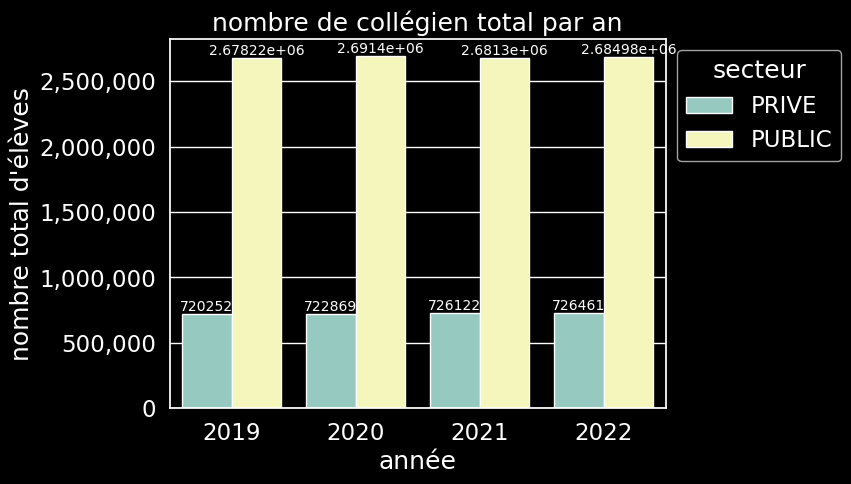

In [123]:
fig,ax = plt.subplots()
sns.barplot(data=france_public_prive,x='rentree_scolaire',y='nombre_eleves_total',hue='secteur',ax=ax)
ax.set_ylim(0)
ax.ticklabel_format(axis='y',style='plain')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ",")))
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_title("nombre de collégien total par an")
ax.set_xlabel("année")
ax.set_ylabel("nombre total d'élèves")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Le college privée concerne environ 20 % des élèves. Les populations restent stables

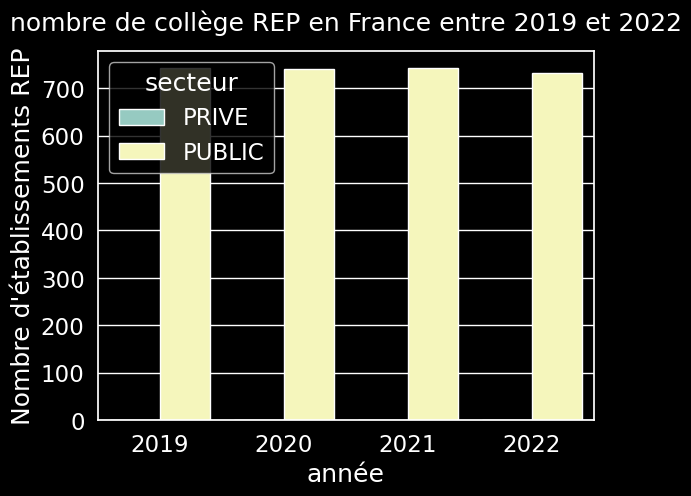

In [126]:
fig,ax = plt.subplots()
sns.barplot(data=france_public_prive,x='rentree_scolaire',y='rep',hue='secteur',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre de collège REP en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Nombre d'établissements REP")
ax.set_ylim(0)
plt.show()

La totalité des établissements en REP sont public.

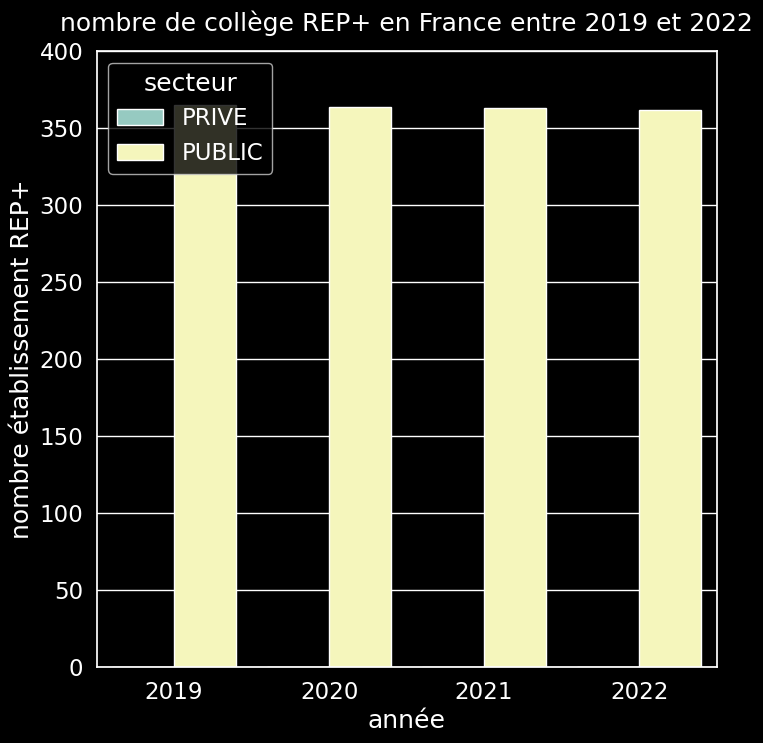

In [127]:
fig,ax = plt.subplots()
fig.set_size_inches(8,8)
sns.barplot(data=france_public_prive,x='rentree_scolaire',y='rep_plus',hue='secteur',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre de collège REP+ en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("nombre établissement REP+")
ax.set_ylim(0,400)
plt.show()

Pareil pour la zone REP+

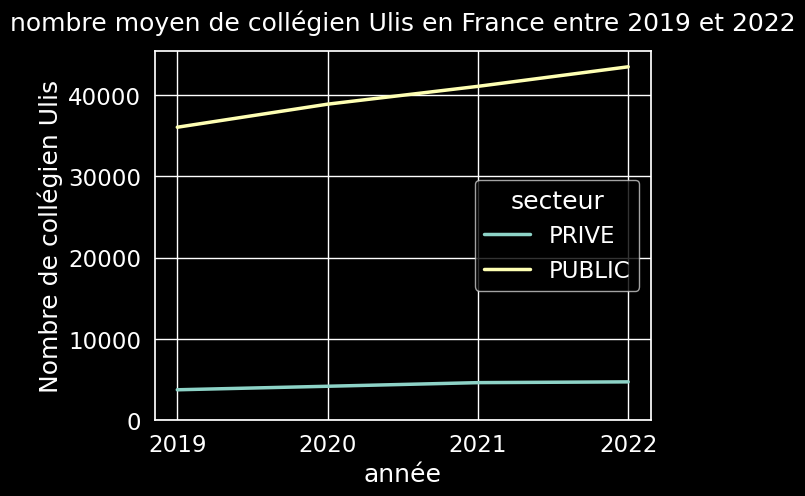

In [128]:
fig,ax = plt.subplots()
sns.lineplot(data=france_public_prive,x='rentree_scolaire',y='nombre_eleves_ulis',hue='secteur',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre moyen de collégien Ulis en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Nombre de collégien Ulis")
ax.set_ylim(0)
plt.show()

Il y a une forte augmentation des collegiens Ulis dans le public. L'augmentation est moindre dans le privée.

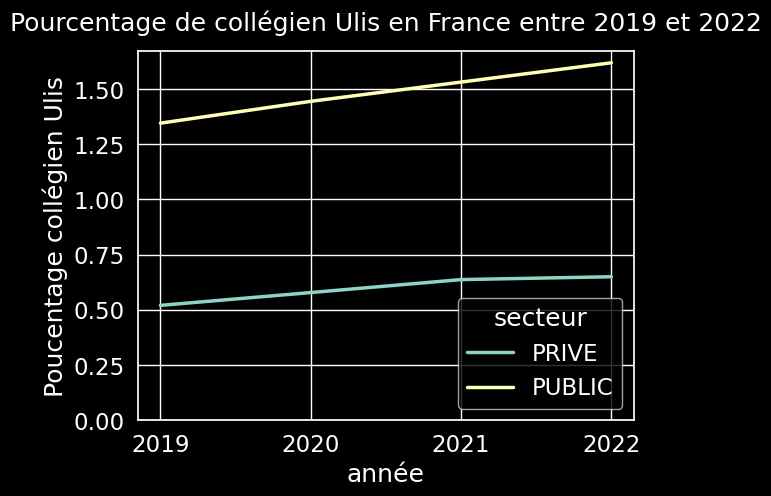

In [129]:
fig,ax = plt.subplots()
sns.lineplot(data=france_public_prive,x='rentree_scolaire',y='pourcentage_ulis_total',hue='secteur',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Pourcentage de collégien Ulis en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Poucentage collégien Ulis")
ax.set_ylim(0)
plt.show()

En pourcentage, il y a 1 point de moins d'élèves Ulis en privée.

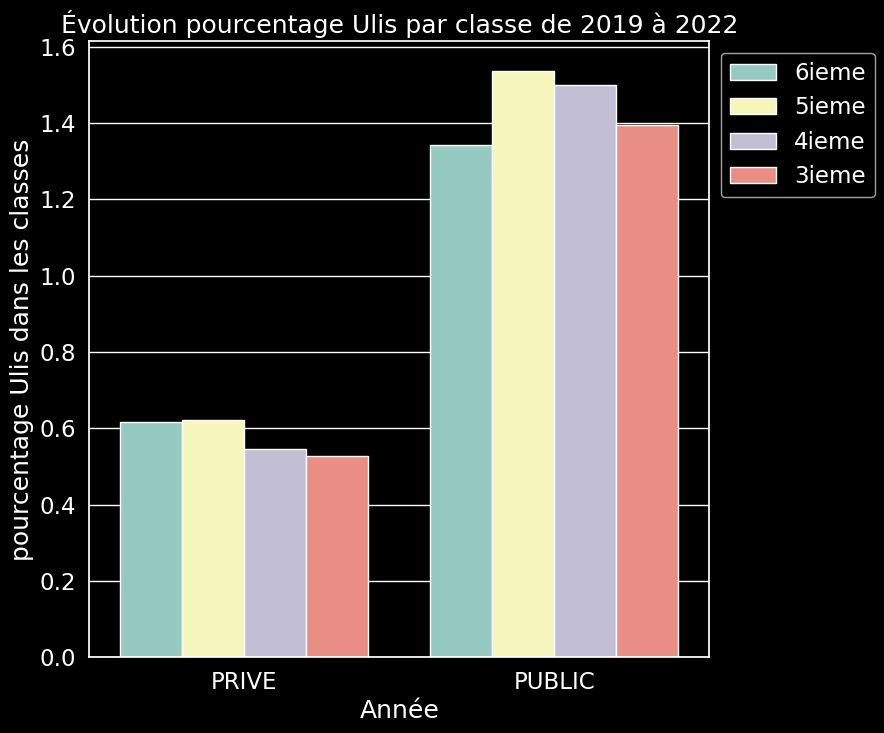

In [130]:
college2020 = france_public_prive[france_public_prive['rentree_scolaire']==2020].copy()
pourcentage_ulis_college = college2020.melt(id_vars=['secteur'],
                                                value_vars=['pourcentage_ulis_6ieme','pourcentage_ulis_5ieme','pourcentage_ulis_4ieme','pourcentage_ulis_3ieme'],
                                                var_name='classe',
                                                value_name='pourcentage')

fig,ax=plt.subplots()
fig.set_size_inches(8,8)

sns.barplot(data=pourcentage_ulis_college,
            x='secteur',
            y='pourcentage',
            hue='classe',
            ax=ax,            
            )

ax.set_title("Évolution pourcentage Ulis par classe de 2019 à 2022")
ax.set_xlabel("Année")
ax.set_ylabel("pourcentage Ulis dans les classes")

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles,labels=['6ieme','5ieme','4ieme','3ieme'])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()
del pourcentage_ulis_college,college2020

Les éléves Ulis en privée restent stable. Alors que dans le public, la population Ulis varient plus.

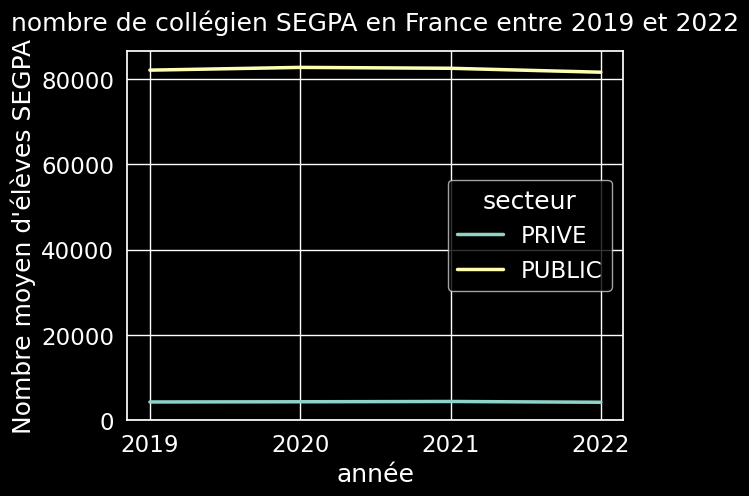

In [131]:
fig,ax = plt.subplots()
sns.lineplot(data=france_public_prive,x='rentree_scolaire',y='nombre_eleves_segpa',hue='secteur',ax=ax)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("nombre de collégien SEGPA en France entre 2019 et 2022",pad=15)
ax.set_xlabel("année")
ax.set_ylabel("Nombre moyen d'élèves SEGPA")
ax.set_ylim(0)
plt.show()

Aucune classe SEGPA en privée.

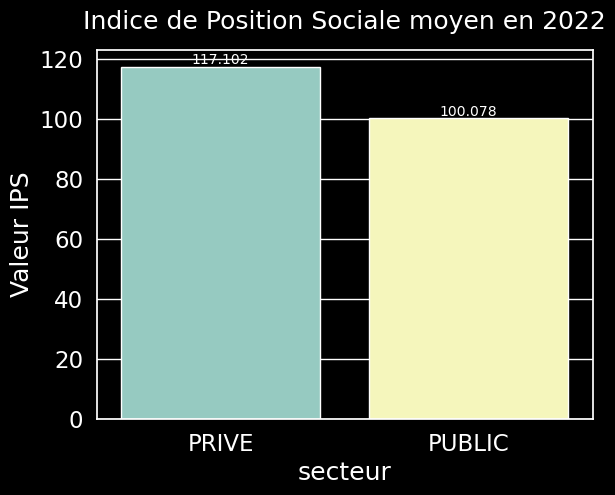

In [132]:
fig,ax = plt.subplots()
sns.barplot(data=france_public_prive, y="ips",ax=ax,estimator="sum",x='secteur',errorbar=None)
ax.set_title("Indice de Position Sociale moyen en 2022",pad=15)
ax.set_ylabel("Valeur IPS")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

Sans surprise, le college public étant payant, l IP est plus élèvé dans le privée.

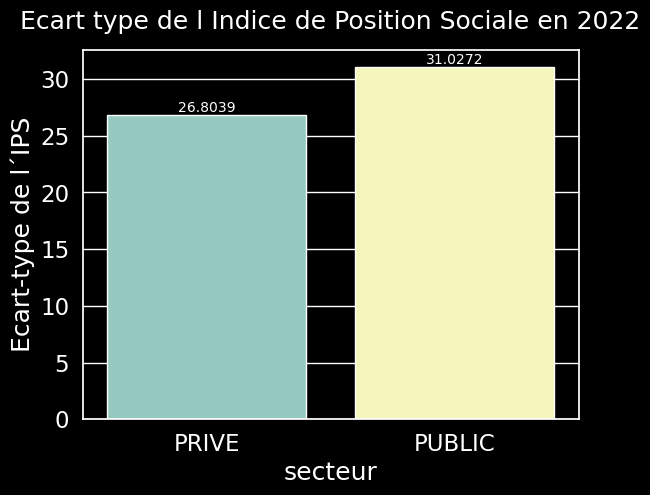

In [133]:
fig,ax = plt.subplots()
sns.barplot(data=france_public_prive,x='secteur', y="ecart_type_de_l_ips",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Ecart type de l Indice de Position Sociale en 2022",pad=15)
ax.set_ylabel("Ecart-type de l´IPS")
ax.bar_label(ax.containers[0], fontsize=10)
ax.set_ylim(0)
plt.show()

L'écart type est moins marqué dans le privée sous contrat.

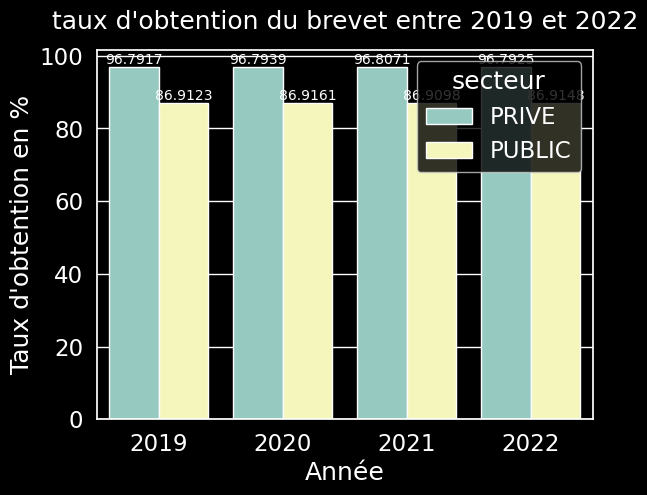

In [134]:
fig,ax = plt.subplots()
sns.barplot(data=france_public_prive, x="rentree_scolaire", y="taux_de_reussite_g",ax=ax,hue="secteur",estimator="sum",errorbar=None)
ax.set_title("taux d'obtention du brevet entre 2019 et 2022",pad=15)
ax.set_ylabel("Taux d'obtention en %")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_ylim(0)
plt.show()

Il y a un écart de 10 points entre les écoles privées et publiques.<br>
Cet écart peut s'expliquer par :
<ul>
    <li>la presence supérieure des Ulis dans le public</li>
    <li>les classes Sepgpa</li>
    <li>un IPS plus élevé</li>
</ul>


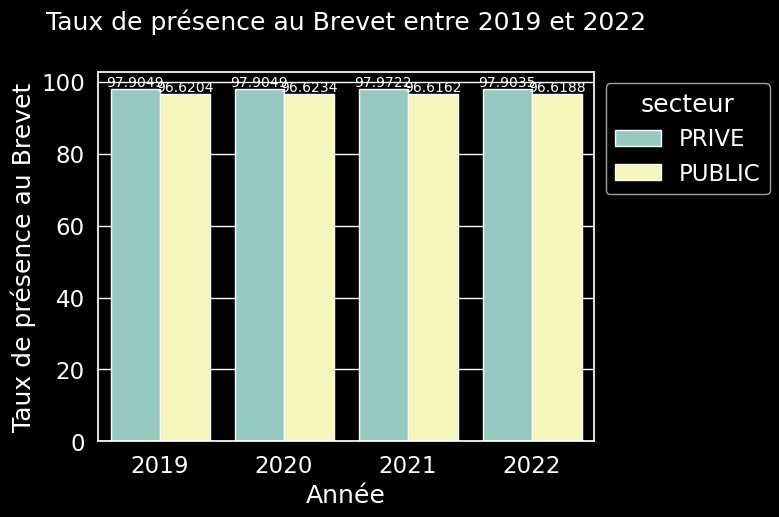

In [135]:
fig,ax = plt.subplots()
sns.barplot(data=france_public_prive, hue='secteur', x="rentree_scolaire", y="part_presents_3eme_ordinaire_total",ax=ax,estimator="sum",errorbar=None)
ax.set_title("Taux de présence au Brevet entre 2019 et 2022",pad=30)
ax.set_ylabel("Taux de présence au Brevet")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_ylim(0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Le collège privée a un taux de présence au brevets supeŕieur de 1.3 %. Les taux sont élevé superieur à 96 %

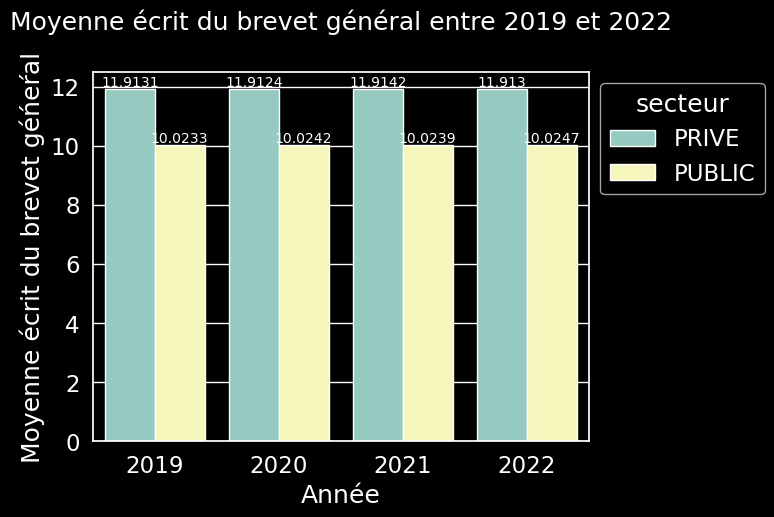

In [136]:
fig,ax = plt.subplots()
sns.barplot(data=france_public_prive, x="rentree_scolaire", y="note_a_l_ecrit_g", hue='secteur',ax=ax,estimator="sum",errorbar=None)
ax.set_title("Moyenne écrit du brevet général entre 2019 et 2022",pad=30)
ax.set_ylabel("Moyenne écrit du brevet géńeŕal")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
ax.set_ylim(0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

On a quaisment 2 points d'écart entre le privée et le public.

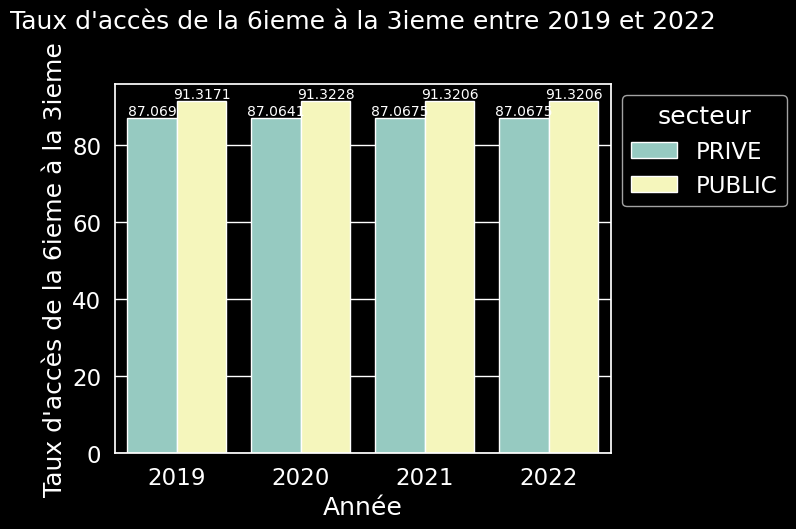

In [137]:
fig,ax = plt.subplots()
sns.barplot(data=france_public_prive, x="rentree_scolaire", y='taux_d_acces_6eme_3eme',hue='secteur',ax=ax,estimator="sum",errorbar=None)
ax.set_title("Taux d'accès de la 6ieme à la 3ieme entre 2019 et 2022",pad=40)
ax.set_ylabel("Taux d'accès de la 6ieme à la 3ieme")
ax.set_xlabel("Année")
ax.bar_label(ax.containers[0], fontsize=10)
ax.bar_label(ax.containers[1], fontsize=10)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylim(0)
plt.show()

Un élèves dans le privée à 13% de chance de ne pas suivre tout son apprentissage dans son collèges. Contre 9% dans le public.

Conclusion :<br>
On observe un gain si l'enfant est placé dans le privée. Mais on ne peut pas affirmer que ce gain est dû au collège, ou au cadre extérieur de l'élève. (IPS).<br>
<br>
Une étude plus approfondi est nécéssaire pour comprendre.

In [138]:
fichier_college = pd.read_csv('donnee_temp/college.csv',dtype={'code_insee_de_la_commune': str,
                                                                'part_presents_3eme_ordinaire_g' : str,
                                                                'part_presents_3eme_ordinaire_p': str,
                                                                'part_presents_3eme_segpa_total' : str})

In [139]:
fichier_college.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32982 entries, 0 to 32981
Data columns (total 62 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rentree_scolaire                          32982 non-null  int64  
 1   region_academique                         32982 non-null  object 
 2   academie                                  32982 non-null  object 
 3   departement                               32982 non-null  object 
 4   commune                                   32982 non-null  object 
 5   numero_college                            32982 non-null  object 
 6   denomination_principale                   32982 non-null  object 
 7   patronyme                                 32927 non-null  object 
 8   secteur                                   32982 non-null  object 
 9   rep                                       32982 non-null  int64  
 10  rep_plus                          

In [163]:
# test statistique sur privé/public resultats et Ulis resultats
pop_privé = fichier_college[fichier_college['secteur']=='PRIVE'].copy()
pop_public = fichier_college[fichier_college['secteur']=='PUBLIC'].copy()

result = perso_stats.ANOVA(df1=pop_privé['nombre_eleves_ulis'],df2=pop_public['nombre_eleves_ulis'])



Interprétation du test:
H0 : Les moyennes des groupes sont égales
H1 : Les moyennes des groupes ne sont pas égales
Étant donné que la p-values est inférieure au niveau de signification alpha = 0.05 ,
on doit rejeter l'hypothèse nulle H0 et retenir l'hypothèse H1.
Le risque de rejeter l'hypothèse nulle H0 alors qu'elle est vraie est inferieur à  0.0 %


Selon le test ANOVA, les populations des collèges privée et public du point de vue des Ulis ne sont pas les mêmes.

In [172]:
pop_privé_ips= pop_privé['ips'].dropna()
pop_public_ips= pop_public['ips'].dropna()

result = perso_stats.ANOVA(df1=pop_privé_ips,df2=pop_public_ips)



Interprétation du test:
H0 : Les moyennes des groupes sont égales
H1 : Les moyennes des groupes ne sont pas égales
Étant donné que la p-values est inférieure au niveau de signification alpha = 0.05 ,
on doit rejeter l'hypothèse nulle H0 et retenir l'hypothèse H1.
Le risque de rejeter l'hypothèse nulle H0 alors qu'elle est vraie est inferieur à  0.0 %


De même avec l indice de position sociale. On a pas la même population entre les colleges privée et public.

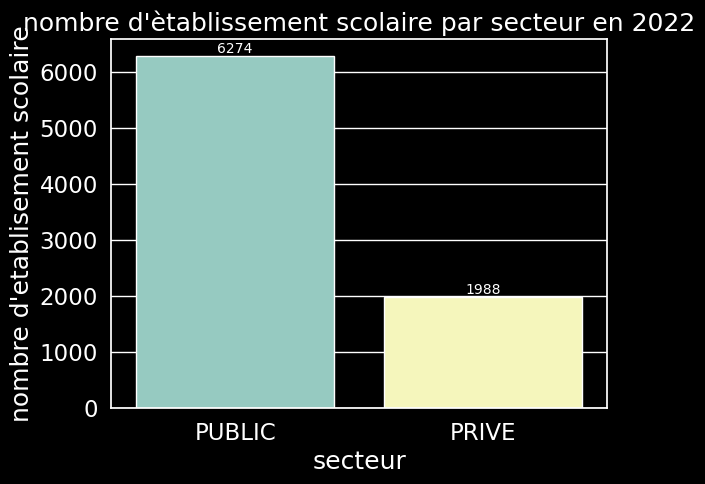

In [141]:
fig, ax = plt.subplots()
fichier_college2020 = fichier_college[fichier_college['rentree_scolaire'] == 2022]
sns.countplot(data=fichier_college2020,x='secteur',ax=ax)
ax.set_title("nombre d'ètablissement scolaire par secteur en 2022")
ax.set_ylabel("nombre d'etablisement scolaire")
ax.bar_label(ax.containers[0], fontsize=10)
plt.show()

In [142]:
liste_classe =['3eme_total','4eme_total','5eme_total','6eme_total']
nb_collegien_total = 0
for a in liste_classe:
    nb_collegien_total += fichier_college2020[a].sum()

#calcul nb de collegien dans le privée
fichier_college_prive_2020 = fichier_college2020[fichier_college2020['secteur']=='PRIVE']
nb_collegien_prive = 0
for a in liste_classe:
    nb_collegien_prive += fichier_college_prive_2020[a].sum()
percent_student_private = nb_collegien_prive/nb_collegien_total *100
print("pourcentage de collégien dans le privée en 2020 : ",percent_student_private)


pourcentage de collégien dans le privée en 2020 :  21.29484909598293


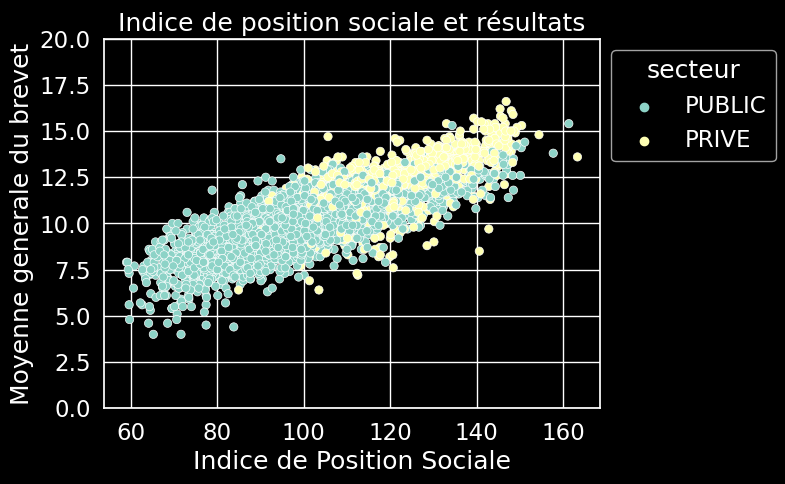

In [143]:
fig,ax = plt.subplots()
sns.scatterplot(data=fichier_college2020,y='note_a_l_ecrit_g',x='ips',hue='secteur',ax=ax)
ax.set_title('Indice de position sociale et résultats')
ax.set_ylabel('Moyenne generale du brevet')
ax.set_xlabel('Indice de Position Sociale')
ax.set_ylim(0,20)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [144]:
# verifier corrélation entre note et ips
corrélation_note_ips = round(fichier_college2020['ips'].corr(fichier_college2020['note_a_l_ecrit_g'])*100,2)
print("On a une corrélation de ",corrélation_note_ips,"%.")

On a une corrélation de  80.85 %.


On s'aperçois que l'IPS et les résultats à l'écrit sont fortement corréllés.

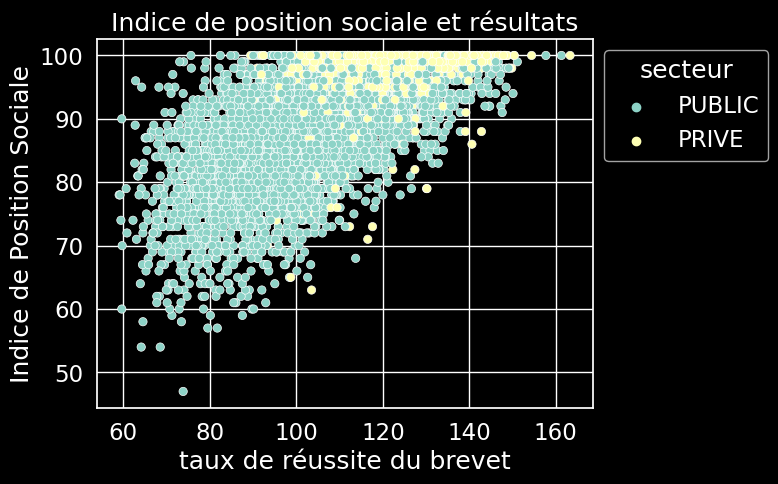

In [145]:
fig,ax = plt.subplots()
sns.scatterplot(data=fichier_college2020,y='taux_de_reussite_g',x='ips',hue='secteur',ax=ax)
ax.set_title('Indice de position sociale et résultats')
ax.set_xlabel('taux de réussite du brevet')
ax.set_ylabel('Indice de Position Sociale')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [146]:
corrélation_note_ips = round(fichier_college2020['ips'].corr(fichier_college2020['taux_de_reussite_g'])*100,2)
print("On a une corrélation de ",corrélation_note_ips,"%.")

On a une corrélation de  60.88 %.


La réussite aux brevet est expliquée pour plus de la moitié par la position sociale des parents.

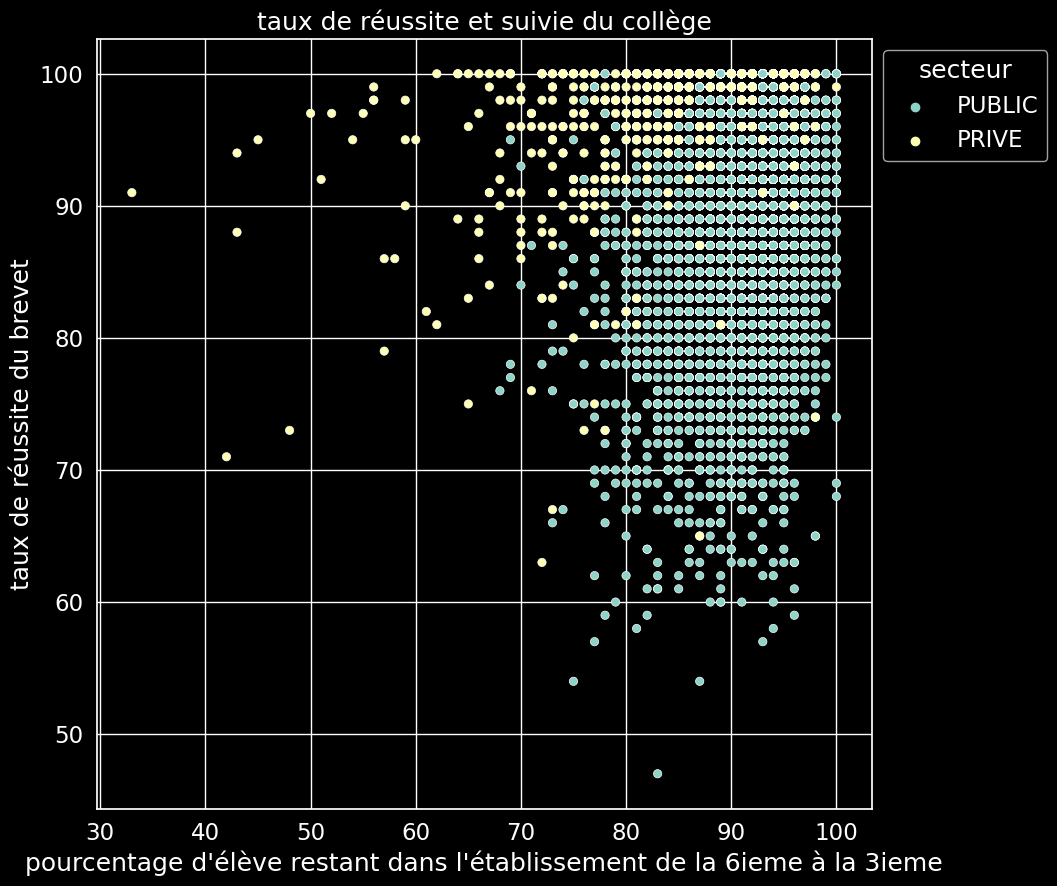

In [147]:
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
sns.scatterplot(data=fichier_college2020,x='taux_d_acces_6eme_3eme' ,y='taux_de_reussite_g',hue='secteur',ax=ax)
ax.set_title('taux de réussite et suivie du collège')
ax.set_ylabel('taux de réussite du brevet')
ax.set_xlabel("pourcentage d'élève restant dans l'établissement de la 6ieme à la 3ieme")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [148]:
0# supression fichiers temporaire
remove("donnee_temp/college.csv")